# RNA覆盖度轨迹预测（RNA coverage track prediction）

## 什么是“RNA覆盖度轨迹”？

轨迹（track） 指的是 沿着基因组坐标的一条连续信号曲线。

RNA覆盖度轨迹 = 在基因组上每个碱基位置的 RNA-seq 读取深度（coverage）形成的曲线。

```yaml
位置:   1   2   3   4   5   6   7   ...
coverage: 0   5   12  15  8   0   20 ...
```
可画成一条曲线（类似 BigWig 格式的信号轨迹）。


## 它与“表达量预测”的关键区别是什么？

与预测表达量不同，模型必须学习启动子、增强子、结合位点、剪接信号等调控规则，理解转录调控机制，才能再现覆盖度轨迹。下表是两者关键区别的比较

| 任务               | 输出                          | 粒度            | 信息量 |
|--------------------|-------------------------------|-----------------|--------|
| 表达量预测         | 一个值（TPM, FPKM）           | 基因级          | 粗     |
| RNA覆盖度轨迹预测 | 整条曲线（base-level / exon-level） | 碱基/结构级     | 极高   |


覆盖度轨迹除了包括表达量，还包含下面的信息：
✅ 外显子结构
✅ 剪接位点
✅ 5’/3’ UTR 使用
✅ 内含子保留
✅ 可变启动子
✅ 3’端偏倚和降解

总结起来，<font color="#FF0000">RNA覆盖度轨迹预测 = 用模型从序列预测 RNA 在基因组上每个位点的表达信号曲线。</font>

它的意义在于：
✅ 比表达量更细粒度
✅ 捕捉剪接、结构、调控机制
✅ 更好理解变异功能
✅ 模拟实验数据
✅ 是构建高质量基因组基础模型的关键任务
✅ 支撑众多下游功能基因组任务

我们的模型在预训练的[Genos-1.2B](https://huggingface.co/BGI-HangzhouAI/Genos-1.2B)基础之上，替换原始输出头为任务专用的卷积模块,采用全参数微调, 基于公共数据库[ENCODE](https://www.encodeproject.org/)和[GTEx](https://www.gtexportal.org/home/), 训练得到我们的RNA覆盖轨迹预测的模型。

**Genos模拟生成多细胞类型RNA-seq表达量与真实测序结果结果相关性0.9+。**

| **细胞类型** | **基因正负链** | **与真实RNA-seq一致性**<br>**（单碱基精度）** | **与真实RNA-seq一致性**<br>**（基因表达量精度）** |
| --- | --- | --- | --- |
| **人B淋巴细胞** | + | **0.933467** | 0.8641 |
| **人B淋巴细胞** | \- | 0.918187 | 0.9081 |
| **NK自然杀伤细胞** | + | **0.908418** | 0.9267 |
| **NK自然杀伤细胞** | \- | 0.856171 | 0.8969 |

为了更好地推动模型服务与科研，我们将覆盖轨迹的预测模型封装成服务，提供API，可以快速接入。**为了您可以顺利使用服务，请确保您已经完成[token](https://cloud.stomics.tech/#/personal-center?tab=apiKey)的申请。**

In [ ]:
# 若环境中没有genos，则需要先安装genos包
# pip install genos

In [ ]:
from genos import create_client

# 创建客户端，替换为你的token
client = create_client(token="<your_api_key>")

完成客户端的创建后，我们可以通过```rna_coverage_track_pred```的函数，快捷地调用服务接口，进行RNA覆盖轨迹预测

- 参数说明
    - chrom: 常染色体编号，例如 "chr1"、"chr2"、...、"chr22" 等，不支持性染色体
    - start_pos: 起始的基因组上的具体碱基位置（1-based coordinate）

In [2]:
result = client.rna_coverage_track_pred("chr19", 39407000)

RNA-seq coverage track prediction completed in 2.2953s


## 返回结果说明

```yaml
{
    'position': 39407000, 
    'sequence': 'ATCGGGG...AATT", 
    'values': {
      'EFO:0002784 total RNA-seq (+)': {'value': [0.1, 0.234, ..., 0.3]},
      'EFO:0002784 total RNA-seq (-)': {'value': [0.1, 0.234, ..., 0.3]},
      'CL:0000623 total RNA-seq (+)': {'value': [0.1, 0.234, ..., 0.3]},
      'CL:0000623 total RNA-seq (-)': {'value': [0.1, 0.234, ..., 0.3]}
}
```

返回结果为一个字典，包括以下字段：
- position 起始位置
- sequence 生成的REF的序列
- values 不同细胞对应的rna正反链对应碱基所预测的表达量

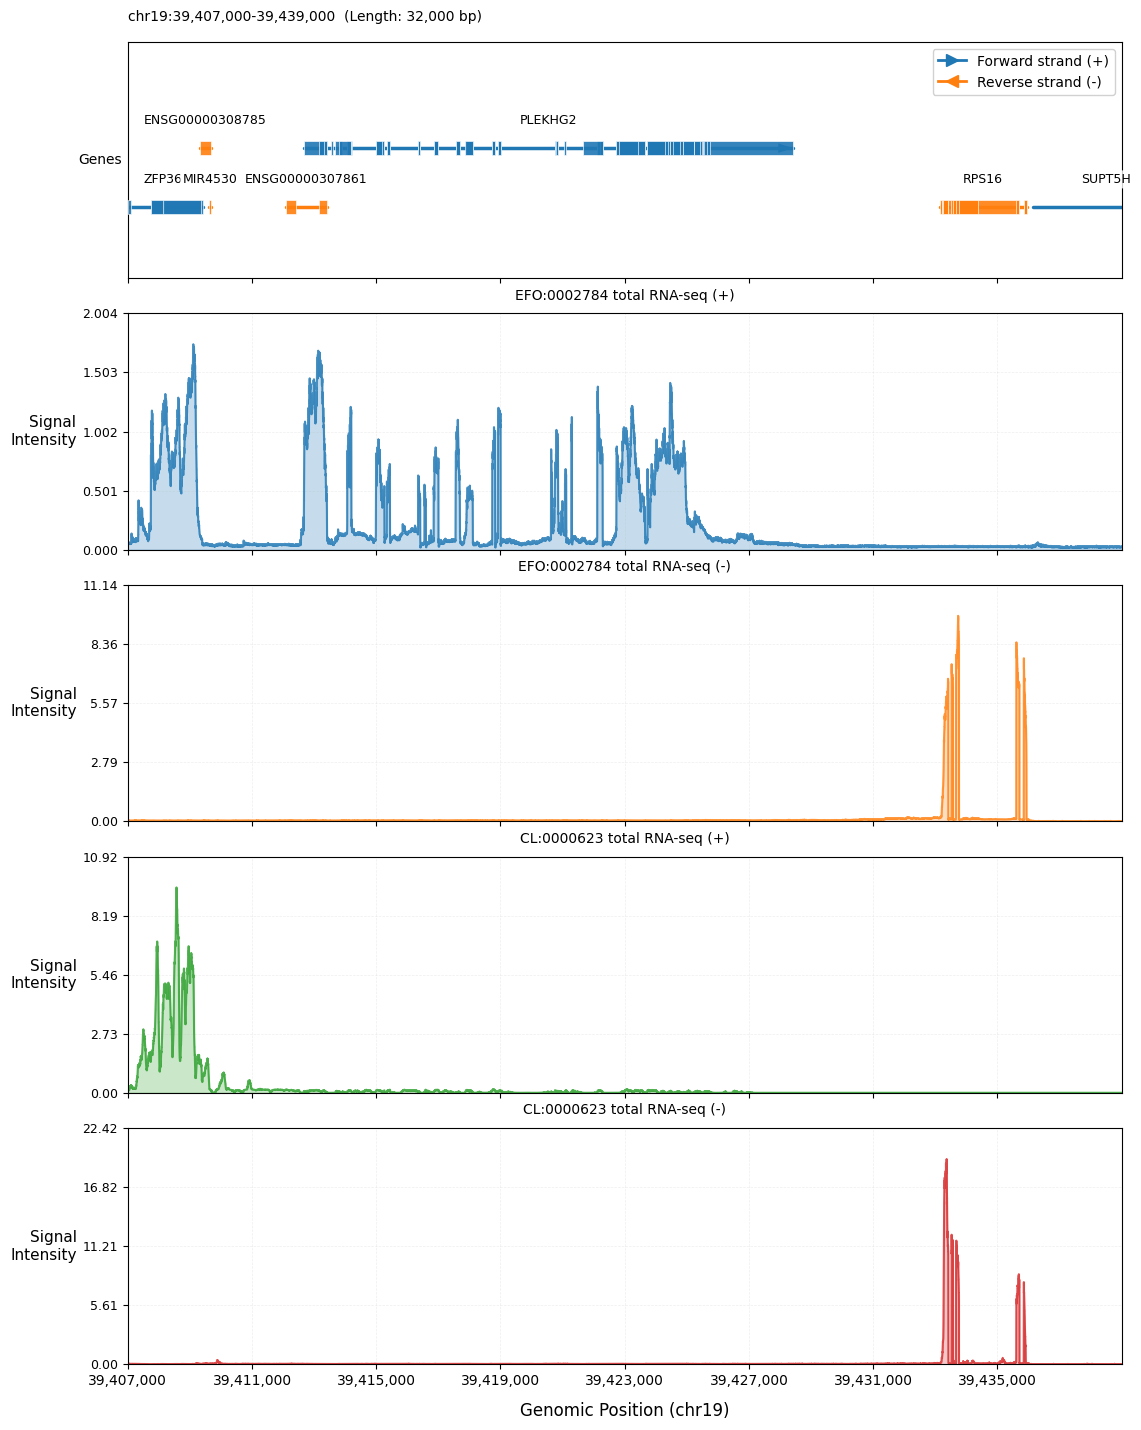

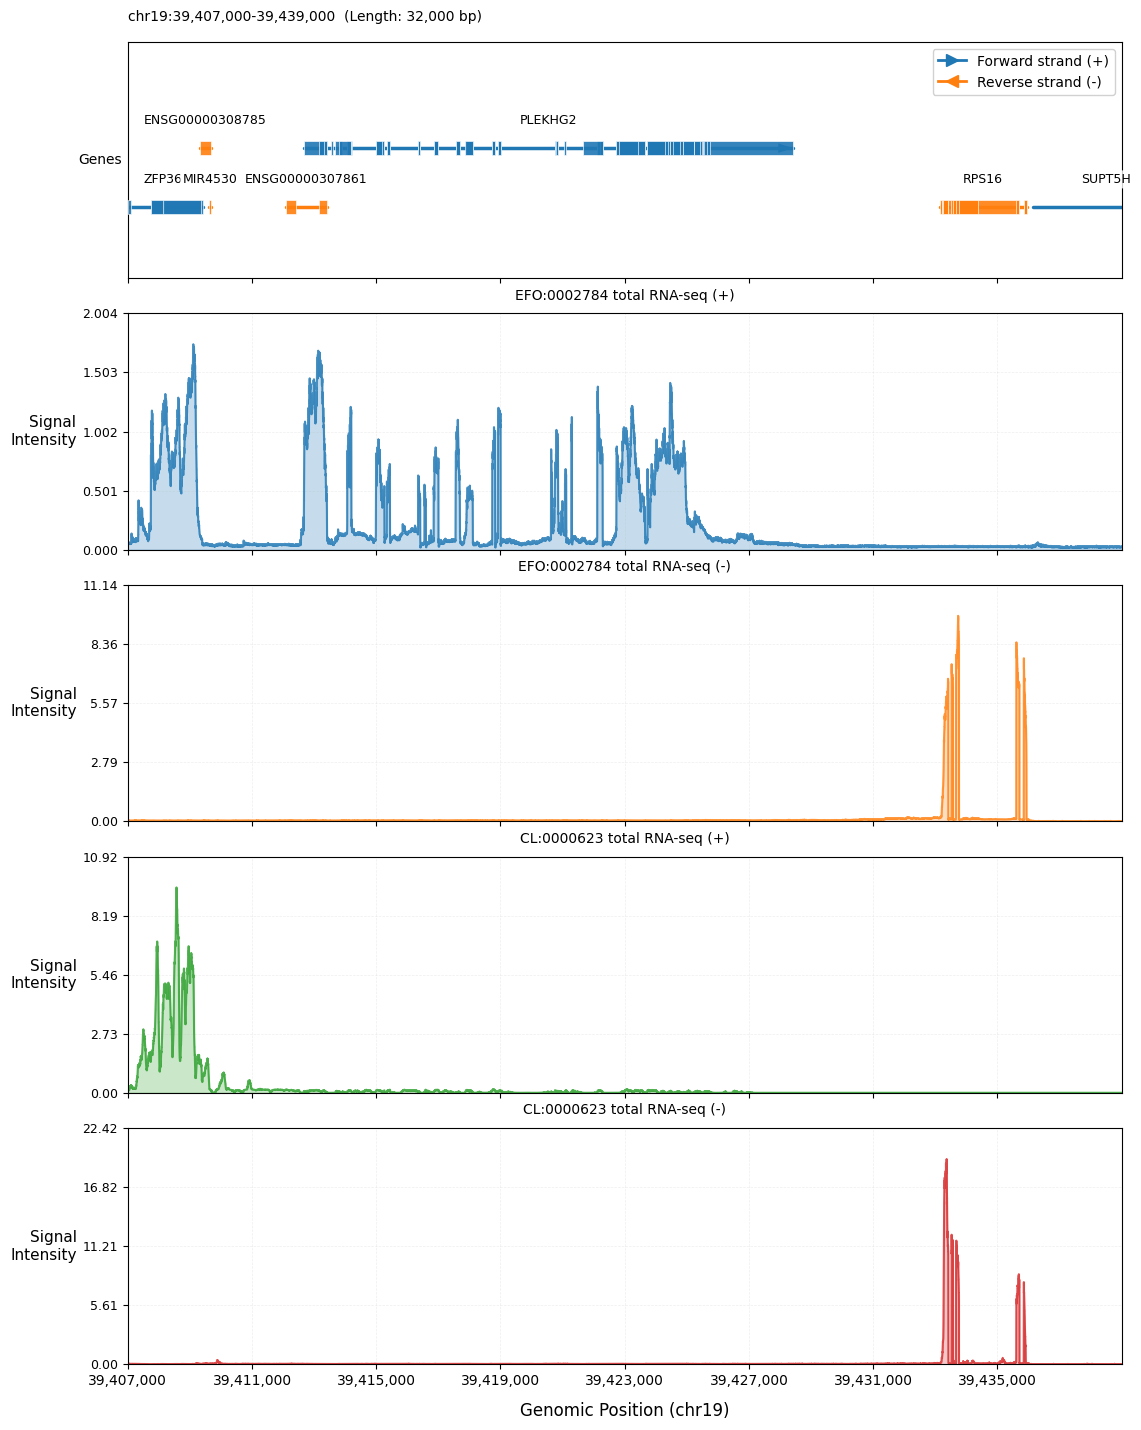

In [3]:
# 结果可视化
from genos.plots.genomic_track_viewer import plot_genomic_track

plot_genomic_track(result)
